
#*Demo de uso de TF-Hub  para detectar múltiples objetos en una imagen*
Basado en info de https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb

1) Cargar Librerías:

In [ ]:
#@title Cargar Librerías
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import tempfile
import time
import os

print("Librerías cargadas.")

Librerías cargadas.


2) Montar el Drive:



In [ ]:
#@title Montar Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/MUCHOS'  #@param {type:"string"}

Mounted at /content/gdrive


3) Seleccionar modelo a cargar y utilizar:

*Nota: MobileNet es más rápido pero Inception tiene mejor precisión.*

In [ ]:
#@title Seleccionar el modelo a usar
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" ]

# carga el módulo a usar
detector = hub.load(module_handle).signatures['default']

print("Modelo ", module_handle, "cargado")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Modelo  https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1 cargado


4) Cargar las imágenes a procesar:

In [ ]:
#@title Cargar imágenes del directorio
# levanta imágenes 
all_images_array = []
auxiPath = path
all_files = os.listdir(auxiPath)
for each_file in all_files:
    if(each_file.endswith(".jpg") or each_file.endswith(".png")):
        all_images_array.append(auxiPath + "/" + each_file)

print(len(all_images_array), " imágenes cargadas.")

5  imágenes cargadas.


5) Ejecutar el modelo seleccionado sobre las imágenes cargadas y mostrar los resultados:

> Modelo  https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1 :
-----------------------------------------------------------------------------
*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/plazaMayo.jpg


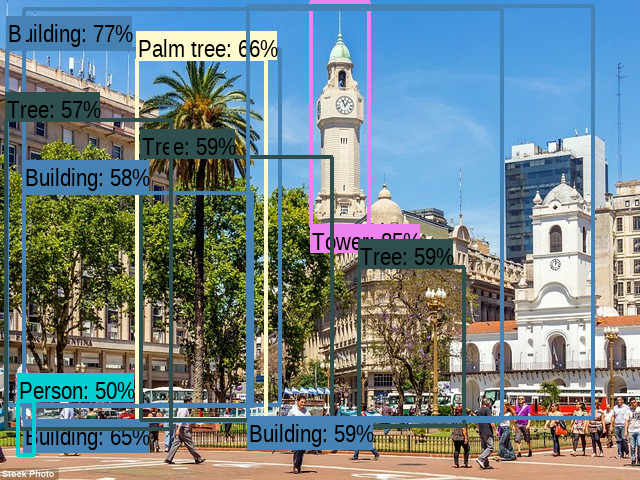

 -- Objetos mostrados: 10 de 100 detectados total.
 -- Objetos detectados con mínimo score 0.50: 10.
 -- Tiempo de procesamiento:  59.51332354545593
-----------------------------------------------------------------------------
*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/asado.jpg


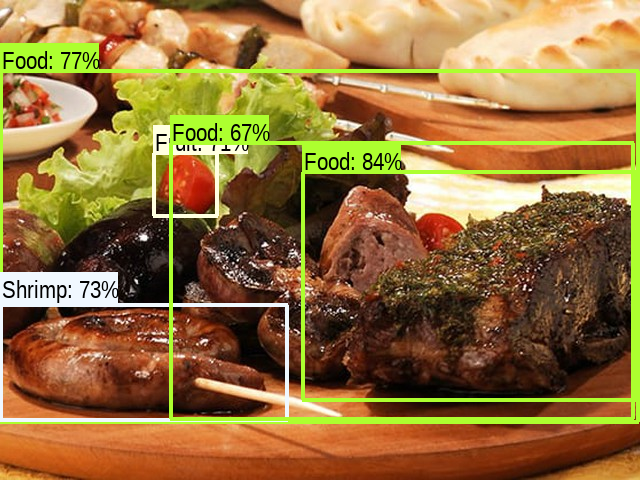

 -- Objetos mostrados: 5 de 100 detectados total.
 -- Objetos detectados con mínimo score 0.50: 5.
 -- Tiempo de procesamiento:  30.9198317527771
-----------------------------------------------------------------------------
*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/obelisco.jpg


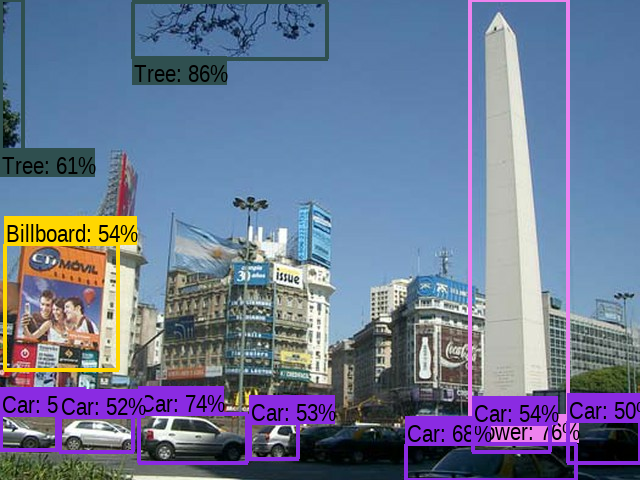

 -- Objetos mostrados: 11 de 100 detectados total.
 -- Objetos detectados con mínimo score 0.50: 11.
 -- Tiempo de procesamiento:  30.931715965270996
-----------------------------------------------------------------------------
*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/laBoca.jpg


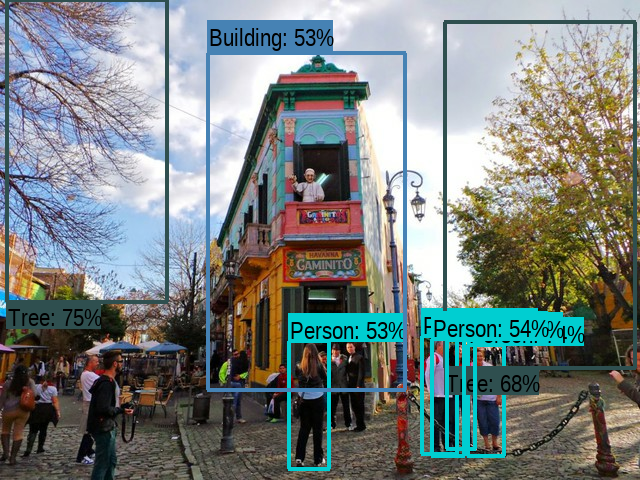

 -- Objetos mostrados: 8 de 100 detectados total.
 -- Objetos detectados con mínimo score 0.50: 8.
 -- Tiempo de procesamiento:  30.58889889717102
-----------------------------------------------------------------------------
*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/animales.jpg


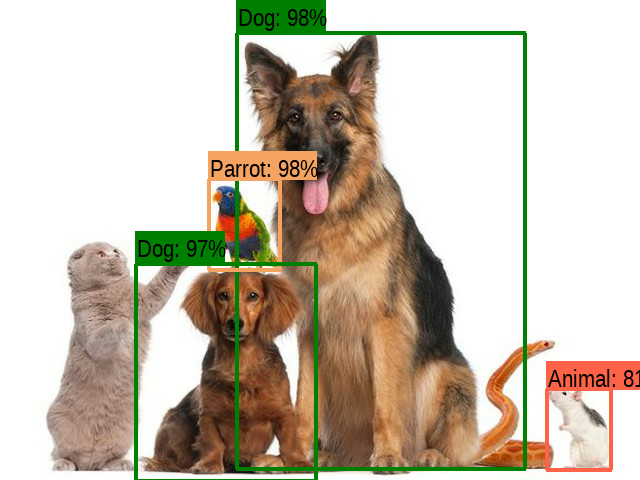

 -- Objetos mostrados: 4 de 100 detectados total.
 -- Objetos detectados con mínimo score 0.50: 4.
 -- Tiempo de procesamiento:  30.83939266204834

-----------------------------------------------------------------------------



In [ ]:
#@title Procesar imágenes
## funciones auxiliares
mostrar_subimagenes_objetos = False #@param {type:"boolean"}

# genera borde para objetos encontrados
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


# indicar objetos detectados en una imagen
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  countBoxDisplayed = 0
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      countBoxDisplayed = countBoxDisplayed + 1
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image, countBoxDisplayed

# define la minima probabilidad que se va a usar para detectar objetos
mininaProbabilidad = 50 #@param {type:"integer"}
min_score_display = mininaProbabilidad / 100
max_boxes_per_image = 50

# indica si muestra detalle de resultados o no
print("> Modelo ", module_handle, ":")

# procesalas imágenes cargadas
for each_image in all_images_array:
  
  print("-----------------------------------------------------------------------------") 
  print("* ", each_image)

  # carga la imagen, la prepar grabandolo en un archivo temporal para su uso
  _, filename = tempfile.mkstemp(suffix=".jpg")
  pil_image = Image.open(each_image)
  pil_image = ImageOps.fit(pil_image, (640, 480), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)

  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img, channels=3)
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

  # procesa la imagen en el modelo previamente cargado
  # devolviendo un vector con los resultados   
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()  
  result = {key:value.numpy() for key,value in result.items()}

  image_with_boxes, countBoxDisplayed = draw_boxes(
      img.numpy(), 
      result["detection_boxes"],
      result["detection_class_entities"], 
      result["detection_scores"],
      max_boxes_per_image, 
      min_score_display)

  # muestra la imagen con los objetos detectados
  imMostrar = Image.fromarray(image_with_boxes, 'RGB')
  display( imMostrar )

  countObjMinScore = 0
  for eachScore in result["detection_scores"]:
    if eachScore >= min_score_display:
      countObjMinScore = countObjMinScore + 1

  print(" -- Objetos mostrados: %d de %d detectados total." % (countBoxDisplayed, len(result["detection_boxes"])) )
  print(" -- Objetos detectados con mínimo score %3.2f: %d." % (min_score_display, countObjMinScore) )
  print(" -- Tiempo de procesamiento: ", (end_time - start_time))

  if mostrar_subimagenes_objetos:
    print("\n")
    imCargada_ancho, imCargada_alto = pil_image.size

    # muestra detalle de los objetos detectados
    for detClass, detBox, detScore in zip( result["detection_class_entities"], result["detection_boxes"],  result["detection_scores"]):    
      if detScore >= min_score_display:
          print("\n    - ", detClass, " : ", detScore, "% : ", detBox)

        # como las coordenadas están normalizadas las debe convertir 
          # teniendo en cuenta el tamaño de la imagen
          # además notar que vienen datas en otro orden
          # - detBox = (ini alto, ini ancho, fin alto, fin ancho)
          # - nuevoRangoIn = (ini ancho, ini alto, fin ancho, fin alto)    
          nuevoRangoIm = (detBox[1] * imCargada_ancho, 
                          detBox[0] * imCargada_alto,
                          detBox[3] * imCargada_ancho,
                          detBox[2] * imCargada_alto) 
          display ( pil_image.crop(nuevoRangoIm) )

print("\n-----------------------------------------------------------------------------\n")